In [1]:
import torch
import torch.nn as nn

from torch import Tensor
import random
import numpy as np

def set_seed(seed_value):
    """ Set seed for reproducibility. """
    random.seed(seed_value)       # Python random module.
    np.random.seed(seed_value)    # Numpy module.
    torch.manual_seed(seed_value)

new_zz = False

K1 = 30
K2 = 20
K3 = 10

class ZigZag(nn.Module):
    def __init__(self, in_features: int, out_features: int, k) -> None:
        super().__init__()
        self.type = 'zigzag'
        self.out_features = out_features
        self.input = nn.Linear(in_features+out_features, K1)
        self.hidden1 = nn.Linear(K1, K2)
        self.hidden2 = nn.Linear(K2, K3)
        self.output = nn.Linear(K3, out_features)

        self.activation = nn.ReLU()

        self.k = k

    def forward(self, x: Tensor, y: Tensor = None) -> Tensor:
        if y is None:
            batch = x.shape[0]
            y = self.k*torch.ones((batch, self.out_features),device=x.device)

        x = torch.cat([x, y], dim=1)

        x = self.activation(self.input(x))
        x = self.activation(self.hidden1(x))
        x = self.activation(self.hidden2(x))
        return self.output(x)

    def uncertainty(self, x: Tensor) -> Tensor:
        y1 = self.forward(x)
        if new_zz: return torch.abs(self.forward(x,y1)) # new zigzag
        else: return torch.abs(self.forward(x,y1)-y1) # original zigzag

    def call_recursively(self, x: Tensor) -> Tensor:
        y1 = self.forward(x)
        if new_zz: return y1+self.forward(x,y1) # new zigzag
        else: return self.forward(x,y1) # original zigzag


In [2]:
!wget https://raw.githubusercontent.com/cvlab-epfl/zigzag/main/exps/data/bostonHousing.txt

--2025-05-29 19:19:35--  https://raw.githubusercontent.com/cvlab-epfl/zigzag/main/exps/data/bostonHousing.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49082 (48K) [text/plain]
Saving to: ‘bostonHousing.txt.5’

bostonHousing.txt.5 100%[===================>]  47.93K  --.-KB/s    in 0.009s  

2025-05-29 19:19:35 (5.20 MB/s) - ‘bostonHousing.txt.5’ saved [49082/49082]



In [3]:
# @title dataset utilities
import os

from torch.utils.data import Dataset, Subset

import numpy as np
import matplotlib.pyplot as plt

def read_txt(fname: str) -> tuple:
    array = np.loadtxt(fname, dtype=float)
    x = array[:,:-1]
    y = array[:,-1]
    return torch.Tensor(x), torch.Tensor(y).unsqueeze(1)

def normalize(tensor: Tensor) -> tuple:
    mean = tensor.mean(dim=0)
    std = tensor.std(dim=0)
    normalized_tensor = tensor - mean
    return normalized_tensor / std, mean, std

class UCIDataset(Dataset):
    def __init__(self, fname: str) -> None:
        super(UCIDataset).__init__()
        x, y = read_txt(fname)
        self.x, self.x_mean, self.x_std = normalize(x)
        self.y, self.y_mean, self.y_std = normalize(y)

    def __len__(self) -> int:
        return self.x.shape[0]

    def __getitem__(self, index: int) -> tuple:
        return self.x[index], self.y[index]

    def corner_plot(self, fig_dir: str = None) -> None:
        n_vars = self.x.shape[1]

        fig, axs = plt.subplots(n_vars, n_vars, figsize=(10,10),layout='constrained')
        for i in range(n_vars):
            for j in range(n_vars):
                if i == j:
                    axs[i,j].hist(self.x[:,i], bins=15, color='skyblue', edgecolor='black',
                                  histtype='stepfilled')

                else:
                    if j<i:
                       pcm = axs[i,j].scatter(self.x[:,i], self.x[:,j], c=self.y , alpha=1.0,
                                        cmap='GnBu',s=5)
                    else:
                        axs[i,j].axis('off')
                if i<n_vars-1:
                    axs[i,j].xaxis.set_visible(False)
                if j > 0:
                    axs[i, j].yaxis.set_visible(False)
        for i in range(n_vars):
            axs[i,0].set_ylabel(f'var {i+1}')
            axs[-1,i].set_xlabel(f'var {i+1}')
            axs[-1,i].set_xlim(axs[-1,i].get_xlim())

        fig.colorbar(pcm, ax=axs[0:2,-1], label=r'$y$')

        if fig_dir is not None:
            plt.savefig(os.path.join(fig_dir,'corner_plot.png'), dpi=300)
        else: plt.show()

    def hist_single_var(self, idx:int, mask=None,fig_dir: str = None) -> None:
        fig,ax = plt.subplots()
        if idx == -1:
            var = self.y.T
            if mask is not None:
                var = var[:,mask]
        else:
            var = self.x[:,idx]
            if mask is not None:
                var = var[mask]


        ax.hist(var, bins='auto', color='skyblue', edgecolor='black', density=False,
                        histtype='stepfilled')

        ax.set_ylabel(r'counts')
        if fig_dir is not None:
            plt.savefig(os.path.join(fig_dir, 'y_hist.png'), dpi=160)
        else: plt.show()

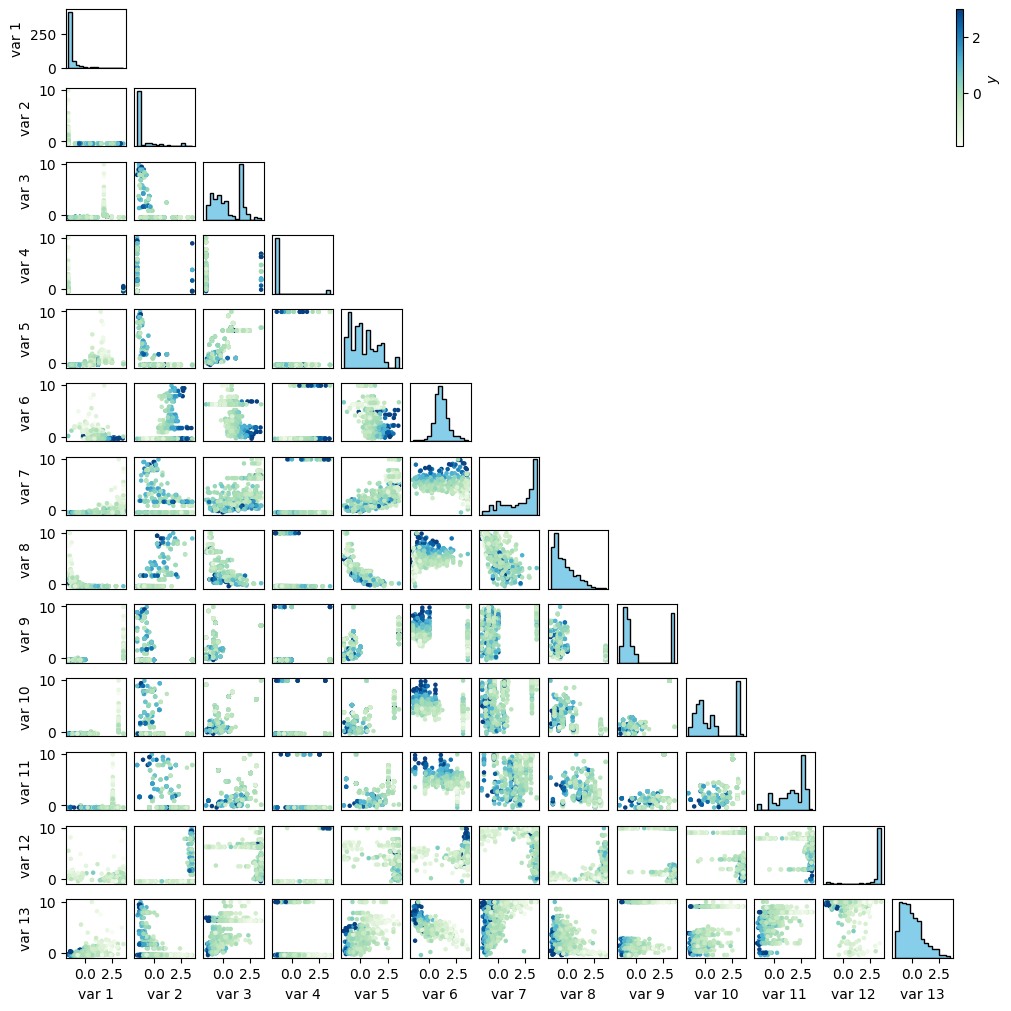

In [4]:
dataset = UCIDataset("bostonHousing.txt")
dataset.corner_plot() # plotting the corner plot can take some time for large datasets

In [5]:
# from torch.utils.data import random_split, DataLoader, Dataset

# def split_by_single_variable(dataset: Dataset, var_idx: int, interval: list) -> tuple:
#     var = dataset.x[:,var_idx]
#     train_cond = (var > interval[0]) * (var < interval[1])

#     train_idx = torch.nonzero(train_cond).squeeze()
#     test_idx = torch.nonzero( ~train_cond).squeeze()
#     train_data = Subset(dataset, train_idx)
#     test_data = Subset(dataset, test_idx)
#     return train_data, test_data

# var = 8 # index: START FROM 0!

# id_data, ood_data = split_by_single_variable(dataset, var, [-10.,0.5 ]) # adjust the parameters depending on the dataset
# print(f'number of id samples : {len(id_data)}')
# print(f'number of ood samples: {len(ood_data)}')

# N_split = int(0.9 * len(id_data))
# train_data, test_data = Subset(id_data, range(N_split)),  Subset(id_data, range(N_split, len(id_data))) #random_split(id_data, [0.9, 0.1])
# batch_size = 32
# train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

# id_data.dataset.hist_single_var(var, mask=id_data.indices)
# ood_data.dataset.hist_single_var(var, mask=ood_data.indices)

from torch.utils.data import random_split, DataLoader, Dataset

def split_by_single_variable(dataset: Dataset, var_idx: int, interval: list) -> tuple:
    var = dataset.x[:,var_idx]
    train_cond = (var > interval[0]) * (var < interval[1])

    train_idx = torch.nonzero(train_cond).squeeze()
    test_idx = torch.nonzero( ~train_cond).squeeze()
    train_data = Subset(dataset, train_idx)
    test_data = Subset(dataset, test_idx)
    return train_data, test_data

# var = 8 # index: START FROM 0!

# id_data, ood_data = split_by_single_variable(dataset, var, [-10.,0.5 ]) # adjust the parameters depending on the dataset
# print(f'number of id samples : {len(id_data)}')
# print(f'number of ood samples: {len(ood_data)}')

N_split = int(0.9 * len(dataset))
train_data, test_data = Subset(dataset, range(N_split)),  Subset(dataset, range(N_split, len(dataset))) #random_split(id_data, [0.9, 0.1])
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

In [6]:
class SingleMLP(nn.Module):
    def __init__(self, in_features, out_features) -> None:
        super().__init__()
        self.type = 'simple_mlp'
        self.out_features = out_features
        self.input = nn.Linear(in_features, K1)
        self.hidden1 = nn.Linear(K1, K2)
        self.hidden2 = nn.Linear(K2, K3)
        self.output = nn.Linear(K3, out_features)

        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.input(x))
        x = self.activation(self.hidden1(x))
        x = self.activation(self.hidden2(x))
        return self.output(x)

class Ensemble():
    def __init__(self, n_models:int, in_features:int, out_features:int):
        self.model_list = []
        self.type = 'ensemble'
        for i in range(n_models):
            self.model_list.append(SingleMLP(in_features, out_features))

    def __call__(self, x):
        y_list = []
        for model in self.model_list:
            y_list.append(model(x))

        return torch.stack(y_list).mean(dim=0)

    def uncertainty(self, x):
        y_list = []
        for model in self.model_list:
            y_list.append(model(x))
        return torch.stack(y_list).var(dim=0)

    def cpu(self):
        for model in self.model_list:
            model.cpu()

class MCDropout(nn.Module):
    def __init__(self, in_features, out_features, p=0.2) -> None:
        super().__init__()
        self.type = 'dropout'
        self.out_features = out_features
        self.input = nn.Linear(in_features, K1)
        self.hidden1 = nn.Linear(K1, K2)
        self.hidden2 = nn.Linear(K2, K3)
        self.output = nn.Linear(K3, out_features)

        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(p=p)

    def forward(self, x):
        x = self.activation(self.input(x))
        x = self.dropout(x)
        x = self.activation(self.hidden1(x))
        x = self.dropout(x)
        x = self.activation(self.hidden2(x))
        x = self.dropout(x)
        return self.output(x)

    def uncertainty(self, x, T):
        self.train()
        N = x.shape[0]
        preds = torch.zeros(T,N)
        for t in range(T):
            preds[t,:] = self.forward(x).squeeze()
        return torch.var(preds, dim=0).unsqueeze(1)


new_zz = False

K1 = 30
K2 = 20
K3 = 10

import torch.nn.init as init

class ZigZag(nn.Module):
    def __init__(self, in_features: int, out_features: int, k) -> None:
        super().__init__()
        self.type = 'zigzag'
        self.out_features = out_features
        self.input = nn.Linear(in_features+out_features, K1)
        self.hidden1 = nn.Linear(K1, K2)
        self.hidden2 = nn.Linear(K2, K3)
        self.output = nn.Linear(K3, out_features)

        self.activation = nn.ReLU()

        self.k = k

        self.init_weights()

    def forward(self, x: Tensor, y: Tensor = None) -> Tensor:
        if y is None:
            batch = x.shape[0]
            # y = torch.zeros((batch, self.out_features),device=x.device)
            y = self.k*torch.ones((batch, self.out_features),device=x.device)

        x = torch.cat([x, y], dim=1)

        x = self.activation(self.input(x))
        x = self.activation(self.hidden1(x))
        x = self.activation(self.hidden2(x))
        return self.output(x)

    def init_weights(self):
        # Set the standard deviation for the initialization
        std_dev = 0.01  # This can be adjusted to increase the variance

        # Initialize weights for each linear layer
        for m in self.modules():
            if isinstance(m, nn.Linear):
                # Use a normal distribution with a higher standard deviation
                # init.normal_(m.weight, mean=0.0, std=std_dev)
                if m.bias is not None:
                    init.constant_(m.bias, 0)  # Initialize biases to zero

    def uncertainty(self, x: Tensor) -> Tensor:
        y1 = self.forward(x)
        if new_zz: return torch.abs(self.forward(x,y1)) # new zigzag
        else: return torch.abs(self.forward(x,y1)-y1) # original zigzag

    def call_recursively(self, x: Tensor) -> Tensor:
        y1 = self.forward(x)
        if new_zz: return y1+self.forward(x,y1) # new zigzag
        else: return self.forward(x,y1) # original zigzag

In [7]:
# @title training utilities
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm

def get_available_device():
    return torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def mean(lst: list) -> float:
    return sum(lst)/len(lst)

def train_epoch(model, dataset, optimizer, loss_fn, device):
    model.train()
    current_loss = 0.0
    for batch in dataset:
        x,y = batch
        x = x.to(device)
        y = y.to(device)

        if model.type == 'simple_mlp' or model.type == 'dropout':
            pred = model(x)
            loss = loss_fn(pred, y)

        elif model.type == 'zigzag':
            pred0 = model(x)
            pred1 = model(x,y )
            if new_zz: loss = loss_fn(pred0,y) + loss_fn(pred1, torch.zeros_like(y)) # new zigzag
            else: loss = loss_fn(pred0,y) + loss_fn(pred1, y) # original zigzag

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        current_loss += loss.item()

    return current_loss / len(dataset), loss

def test_epoch(model, dataset, metrics, device):
    model.eval()
    with torch.no_grad():
        res_list = [0. for metric in metrics]
        N = len(dataset)
        for batch in dataset:
            x,y = batch
            x = x.to(device)
            y = y.to(device)
            pred = model(x)
            for i, metric in enumerate(metrics):
                res_list[i] += metric(pred, y)/N
    return res_list

def plot_history(training_history, test_history, model_type, fig_dir=None):
    if model_type == 'ensemble':
        epochs = len(training_history[0])
        test_history = torch.Tensor(test_history)
        training_history = torch.Tensor(training_history)
    else:
        epochs = len(training_history)
        test_history = torch.Tensor(test_history).unsqueeze(0)
        training_history = torch.Tensor(training_history).unsqueeze(0)

    fig, ax = plt.subplots()
    for i in range(training_history.shape[0]):
        # 1) train / test
        ax.semilogy(range(1, epochs+1), training_history[i],
                    color='tab:blue',linewidth=1, alpha=0.5)
        ax.semilogy(range(1, epochs+1), test_history[i,:,0],
                    color='black',linewidth=1, alpha=0.5)
    ax.semilogy(range(1, epochs+1), training_history.mean(dim=0), color='tab:blue', label='Training')
    ax.semilogy(range(1, epochs+1), test_history.mean(dim=0)[:,0], 'k--', label='Test')
    ax.set_xlim([1,epochs])
    ax.set_xlabel(r'epoch')
    ax.set_ylabel(r'$\ell$')
    ax.set_title(f'Training history; {model_type}')
    ax.legend()
    if fig_dir is not None:
        fname = os.path.join(fig_dir, f'training_history_{model_type}.png')
        plt.savefig(fname, dpi=160)
    else: plt.show()

    # 2) test metrics
    n_metrics = test_history.shape[2]
    fig, axs = plt.subplots(1, n_metrics, layout='constrained')
    if n_metrics == 1:
        for i in range(training_history.shape[0]):
            axs.semilogy(range(1,epochs+1), test_history[i,:],
                         color='tab:blue',linewidth=1, alpha=0.5)
        axs.semilogy(range(1,epochs+1), test_history.mean(dim=0)[:], color='tab:blue')
        axs.set_xlim([1,epochs])
        axs.set_xlabel('epoch')
        axs.set_title(f'Metric')
        axs.set_ylabel('metric')
    else:
        for i in range(n_metrics):
            axs[i].semilogy(range(1,epochs+1), test_history[:,i])
            axs[i].set_xlim([1,epochs])
            axs[i].set_xlabel('epoch')
            axs[i].set_title(f'Metric {i+1}')
        axs[0].set_ylabel('metric')
    if fig_dir is not None:
        fname = os.path.join(fig_dir, f'test_history_{model_type}.png')
        plt.savefig(fname, dpi=160)
    else: plt.show()


def train_model(model, train_data, test_data, optimizer, loss_fn, metrics, epochs, fig_dir=None):
    print('+---------------------+')
    print('|   Training start    |')
    print('+---------------------+')

    device = get_available_device()
    model.to(device)

    training_history = []
    testing_history = []
    lr_scheduler = ReduceLROnPlateau(optimizer, factor=0.5)
    for epoch in tqdm(range(epochs)):
        current_loss, train_loss = train_epoch(model, train_data, optimizer, loss_fn,
                                               device)
        training_history.append(current_loss)
        testing_history.append(test_epoch(model, test_data, metrics, device))
        lr_scheduler.step(train_loss)

    print('\n')
    print('+---------------------+')
    print('|   Training ended    |')
    print('+---------------------+')

    plot_history(training_history, testing_history, model.type, fig_dir)

    return model

def train_ensemble(ensemble, train_data, test_data, lr, loss_fn, metrics, epochs, fig_dir=None):
    print('+---------------------+')
    print('|   Training start    |')
    print('+---------------------+')
    training_history_list = []
    testing_history_list = []
    device = get_available_device()

    for model in ensemble.model_list:
        model.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        lr_scheduler = ReduceLROnPlateau(optimizer, factor=0.5)
        training_history = []
        testing_history = []
        for epoch in tqdm(range(epochs)):
            current_loss, train_loss = train_epoch(model, train_data, optimizer, loss_fn,
                                                   device)
            training_history.append(current_loss)
            testing_history.append(test_epoch(model, test_data, metrics,device))
            lr_scheduler.step(train_loss)
        training_history_list.append(training_history)
        testing_history_list.append(testing_history)

    print('\n')
    print('+---------------------+')
    print('|   Training ended    |')
    print('+---------------------+')

    plot_history(training_history_list, testing_history_list, ensemble.type, fig_dir)

    return ensemble

# Vanilla Model

In [8]:
set_seed(42)

+---------------------+
|   Training start    |
+---------------------+


100%|██████████| 30/30 [00:01<00:00, 25.34it/s]




+---------------------+
|   Training ended    |
+---------------------+


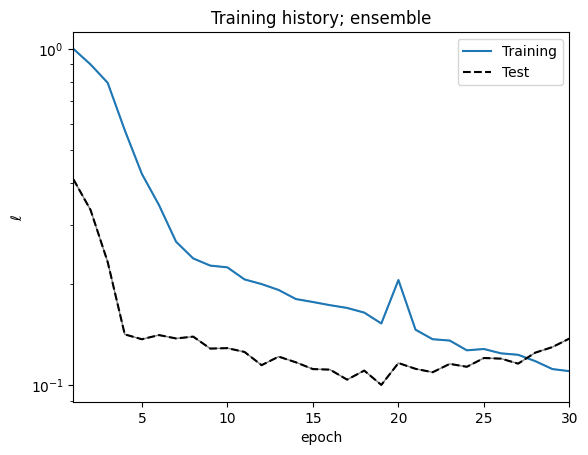

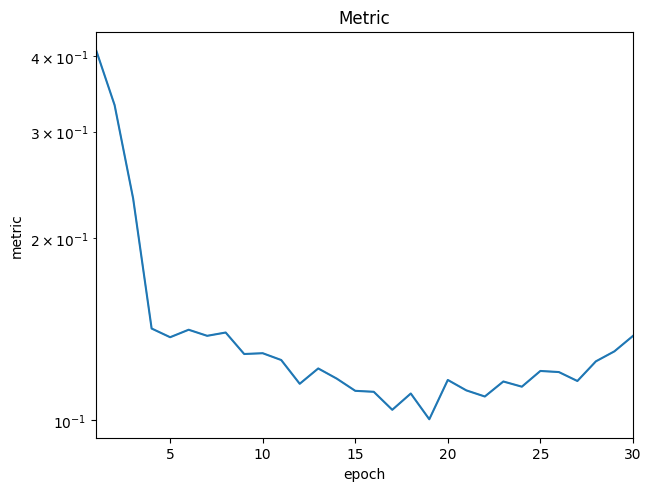

In [9]:
from tqdm import tqdm

# set_seed(1)

in_features = 13
out_features = 1
n_models = 1
# p = 0.2 # dropout probability

# zigzag = ZigZag(in_features, out_features, k=50)
ensemble = Ensemble(n_models, in_features, out_features)
# dropout = MCDropout(in_features, out_features, p)

lr = 1e-3
epochs = 30
metrics = [nn.MSELoss()]

# optimizer = torch.optim.Adam(zigzag.parameters(), lr=lr)
loss_fn = nn.MSELoss()

# zigzag = train_model(zigzag, train_loader, test_loader,
#                     optimizer, loss_fn, metrics, epochs)

ensemble = train_ensemble(ensemble, train_loader, test_loader,
                          lr, loss_fn, metrics, epochs)

# optimizer = torch.optim.Adam(dropout.parameters(), lr=lr)
# dropout = train_model(dropout, train_loader, test_loader,
#                     optimizer, loss_fn, metrics, epochs)

In [10]:
from sklearn.metrics import r2_score

# set_seed(1)

ensemble.cpu()

x_train, y_train = train_data[:]
x_test, y_test = test_data[:]

dropout_probs = [0.0, 0.05, 0.10, 0.15, 0.20]

errors = []
for p in dropout_probs:
    # Generate a mask that keeps (1 - p) proportion of values
    mask = torch.rand_like(x_test) > p
    
    # Apply the mask to zero out p% of values
    x_test_corrupted = x_test * mask
    pred_test = ensemble(x_test_corrupted)
    
    err_array = torch.abs(y_test - pred_test).ravel().tolist()
    errors.append(err_array)

vanilla_errors = np.array(errors)

# ITTT

+---------------------+
|   Training start    |
+---------------------+


100%|██████████| 30/30 [00:01<00:00, 21.89it/s]




+---------------------+
|   Training ended    |
+---------------------+


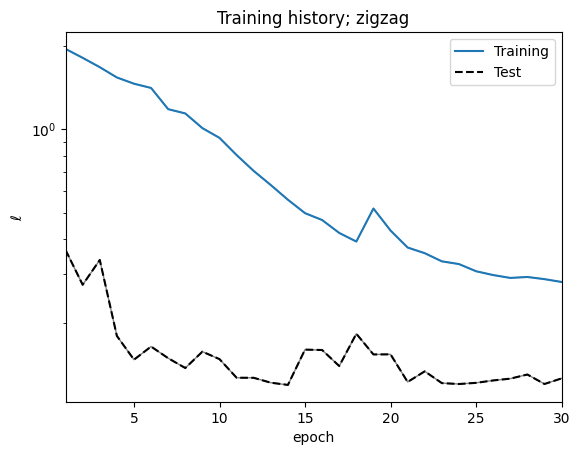

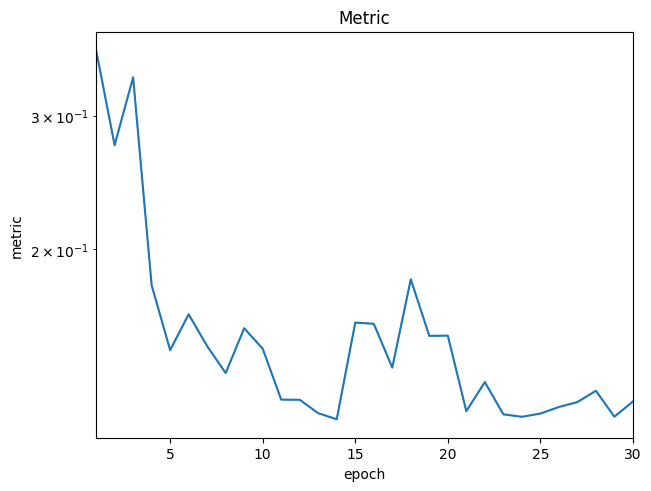

In [11]:
from tqdm import tqdm

# set_seed(1)

in_features = 13
out_features = 1
n_models = 1

zigzag = ZigZag(in_features, out_features, k=50)

lr = 1e-3
epochs = 30
metrics = [nn.MSELoss()]

optimizer = torch.optim.Adam(zigzag.parameters(), lr=lr)
loss_fn = nn.MSELoss()

zigzag = train_model(zigzag, train_loader, test_loader,
                     optimizer, loss_fn, metrics, epochs)

In [12]:
from copy import deepcopy
import torch.optim as optim
import tqdm
from torch.utils.data import TensorDataset

device="cuda"

ittt_results = {}
for bs in [2, 5, 8]:

    dropout_probs = [0.0, 0.05, 0.10, 0.15, 0.20]
    
    errors = []
    for p in dropout_probs:
    
        x_test, y_test = test_data[:]
        
        mask = torch.rand_like(x_test) > p
        x_test = x_test * mask
        dataset = TensorDataset(x_test, y_test)
        zigzag_test_loader = DataLoader(dataset, batch_size=bs, shuffle=False)
        
        def noise_uncertainty(model, model_original, data):
        #     y_1 = model(data.cuda())
        #     copy_data = deepcopy(data)
        #     batch_mask = data.batch
            
        #     for i in range(len(y_1)):
        #         #copy_data.x[batch_mask == i, 2] = y_1[i].detach() / 500.0
        #         copy_data.x[batch_mask == i, 2] = y_1[i] / 500.0
                
        #     y_2 = model_original(copy_data.cuda())
        #     return (y_1 - y_2).abs().mean(), y_2, y_1
            x, y = data
            x = x.to(device)
            y1 = model.forward(x)
            y2 = model_original.forward(x,y1)
            return (y1 - y2).abs().mean(), y2, y1 # original zigzag
        
        
        def ttt_one_instance(x, f_ttt, f, optimizer, n_steps, n_classes=10):
          f_ttt.load_state_dict(f.state_dict())  # reset f_ttt to f
          f_ttt.train()
          f.eval()
          for step in range(n_steps):
            loss, y_1, y_2 = noise_uncertainty(f_ttt, f, x)
        #     if y[0].item() != y_1[0].argmax().item() and (step == 0 or step == n_steps - 1):
        #       print(f'step {step}: loss={loss.item()}')
        #       print(y_0[0].argmax().item(), y_1[0].argmax().item(), y_2[0].argmax().item(), y[0].item())
            #print(loss, y_1, y_2)
            optimizer.zero_grad()
            loss.backward()
        #     if f_ttt.f2.fc2.weight.grad.var() == 0:
        #       print('zero grad')
            optimizer.step()
          f_ttt.eval()
          _, y_1, y_2 = noise_uncertainty(f_ttt, f, x)
          return y_1, y_2
        
        
        def ttt(f, test_loader, n_steps, lr):
            f_ttt = deepcopy(f)
            f.eval()
            optimizer = optim.Adam(f_ttt.parameters(), lr=lr)
            
        #     # List of layers to optimize
        #     layers_to_optimize = [
        #         f_ttt.block1,
        # #         f_ttt.block2,
        # #         f_ttt.block3,
        # #         f_ttt.block4,
        # #         f_ttt.block5,
                
        # #         f_ttt.fc1,
        # #         f_ttt.fc2,
        # #         f_ttt.fc3,
        # #         f_ttt.fc4
        #     ]
        
            # Extract parameters from those layers
        #     params_to_optimize = []
        #     for layer in layers_to_optimize:
        #         params_to_optimize += list(layer.parameters())
            
        #     optimizer = optim.Adam(params_to_optimize, lr=lr)
        
            t = tqdm.trange(len(test_loader), desc='Current Loss = ', leave=True)
            errors = []
            targets = []
            for _, batch in zip(t, test_loader):
        #         print(batch[0].shape)
                y_hat_1, y_hat_2 = ttt_one_instance(batch, f_ttt, f, optimizer, n_steps)
        #         print(y_hat_2[:, 0].detach().cpu().shape, batch.y.shape)
        #         print(y_hat_2[:, 0].detach().cpu().shape, batch[1][:, 0].cpu().shape)
                mae = torch.abs(y_hat_2[:, 0].detach().cpu() - batch[1][:, 0].cpu()).numpy().ravel().tolist()
        #         print(len(mae))
                targets += batch[1].ravel().tolist()
                errors += mae #.append(mae)
                t.set_description(f"Current Loss = {sum(errors) / len(errors)}", refresh=True)
        
            return np.array(errors), np.array(targets)
        
        err_array, _ = ttt(zigzag.to(device), zigzag_test_loader, n_steps=2, lr=1e-4)
        errors.append(err_array.ravel().tolist())
    ittt_errors = np.array(errors)
    ittt_results[bs] = ittt_errors

Current Loss = 0.29106296248295727: 100%|██████████| 7/7 [00:00<00:00, 211.94it/s]


# ActMAD

In [13]:
from torch_ttt.engine.actmad_engine import ActMADEngine

In [14]:
engine = ActMADEngine(
    model = ensemble.model_list[0],
    features_layer_names="hidden1",
    optimization_parameters = {
        "num_steps": 2,
        "lr": 1e-4
    } 
)

In [15]:
# compute statistic for actmad
engine.compute_statistics(DataLoader(x_train))

In [16]:
from torch.utils.data import TensorDataset

x_test, y_test = test_data[:]
# x_ood, y_ood = ood_data[:]

# set_seed(1)

actmad_results = {}
for bs in [2, 5, 8]:

    dropout_probs = [0.0, 0.05, 0.10, 0.15, 0.20]
    
    errors = []
    for p in dropout_probs:

        # Generate a mask that keeps (1 - p) proportion of values
        mask = torch.rand_like(x_test) > p
        
        # Apply the mask to zero out p% of values
        x_test = x_test * mask

        
        dataset = TensorDataset(x_test, y_test)
        zigzag_test_loader = DataLoader(dataset, batch_size=bs, shuffle=False)

        import tqdm
        
        def ttt_actmad(f, test_loader):
            f.eval()
        
            t = tqdm.trange(len(test_loader), desc='Current Loss = ', leave=True)
            errors = []
            targets = []
            for _, batch in zip(t, test_loader):
                y_hat_1, _ = engine(batch[0])
        #         print(y_hat_1)
                mae = torch.abs(y_hat_1[:, 0].detach().cpu() - batch[1][:, 0].cpu()).numpy().ravel().tolist()
                targets += batch[1].ravel().tolist()
                errors += mae #.append(mae)
                t.set_description(f"Current Loss = {sum(errors) / len(errors)}", refresh=True)
        
            return np.array(errors), np.array(targets)
        
        err_array, _ = ttt_actmad(engine, zigzag_test_loader)
        errors.append(err_array.ravel().tolist())
        actmad_errors = np.array(errors)
    actmad_results[bs] = actmad_errors

Current Loss = :   0%|          | 0/26 [00:00<?, ?it/s]/scratch/cvlab/home/durasov/miniconda/envs/ittt/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
Current Loss = 0.261474436968565:  96%|█████████▌| 25/26 [00:00<00:00, 248.61it/s]/scratch/cvlab/home/durasov/miniconda/envs/ittt/lib/python3.8/site-packages/torch_ttt/engine/actmad_engine.py:109: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1808.)
  features_vars = [torch.var(feature, dim=0) for feature in features]
Current Loss = nan: 100%|██████████| 26/26 [00:00<00:00, 247.44it/s]              


cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu


Current Loss = 0.28886459425091743:   0%|          | 0/26 [00:00<?, ?it/s]

cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu


Current Loss = 0.3140996354818344:   0%|          | 0/26 [00:00<?, ?it/s] 

cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu


Current Loss = 0.34879155457019806:   0%|          | 0/26 [00:00<?, ?it/s]

cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu


Current Loss = nan: 100%|██████████| 26/26 [00:00<00:00, 254.34it/s]      


cpu cpu


Current Loss = 0.4260582041740417:   0%|          | 0/26 [00:00<?, ?it/s] 

cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu


Current Loss = nan: 100%|██████████| 26/26 [00:00<00:00, 255.74it/s]     


cpu cpu
cpu cpu


Current Loss = nan: 100%|██████████| 11/11 [00:00<00:00, 246.70it/s]      


cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu


Current Loss = nan: 100%|██████████| 11/11 [00:00<00:00, 246.16it/s]      


cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu


Current Loss = 0.5503764450550079:   0%|          | 0/11 [00:00<?, ?it/s]

cpu cpu
cpu cpu


Current Loss = nan: 100%|██████████| 11/11 [00:00<00:00, 242.42it/s]      


cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu


Current Loss = nan: 100%|██████████| 11/11 [00:00<00:00, 245.05it/s]      


cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu


Current Loss = 0.4663253426551819:   0%|          | 0/11 [00:00<?, ?it/s]

cpu cpu
cpu cpu
cpu cpu
cpu cpu


Current Loss = 0.4243736982345581:   0%|          | 0/11 [00:00<?, ?it/s]

cpu cpu
cpu cpu
cpu cpu


Current Loss = nan: 100%|██████████| 11/11 [00:00<00:00, 242.79it/s]      


cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu


Current Loss = 0.5066268847634395:   0%|          | 0/7 [00:00<?, ?it/s]

cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu


Current Loss = 0.461915128225205: 100%|██████████| 7/7 [00:00<00:00, 240.59it/s]


cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu


Current Loss = 0.44819558893933015: 100%|██████████| 7/7 [00:00<00:00, 240.00it/s]

cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu



Current Loss = :   0%|          | 0/7 [00:00<?, ?it/s]

cpu cpu
cpu cpu


Current Loss = 0.4539833569935724: 100%|██████████| 7/7 [00:00<00:00, 237.06it/s]


cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu


Current Loss = 0.5051714178795615:   0%|          | 0/7 [00:00<?, ?it/s] 

cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu


Current Loss = 0.4568979894998027: 100%|██████████| 7/7 [00:00<00:00, 238.94it/s]


cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu


Current Loss = 0.4714321418135774: 100%|██████████| 7/7 [00:00<00:00, 241.88it/s]

cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu
cpu cpu


In [17]:
M = len(vanilla_errors[0]) # number of samples
NOT_OPTIMIZED = [s for t in vanilla_errors for s in t][M:]

ITTT_BATCH_2 = [s for t in ittt_results[2] for s in t][M:]
ITTT_BATCH_5 = [s for t in ittt_results[5] for s in t][M:]
ITTT_BATCH_8 = [s for t in ittt_results[8] for s in t][M:]

ACTMAD_2_batch = [s for t in actmad_results[2] for s in t][M:]
ACTMAD_5_batch = [s for t in actmad_results[5] for s in t][M:]
ACTMAD_8_batch = [s for t in actmad_results[8] for s in t][M:]

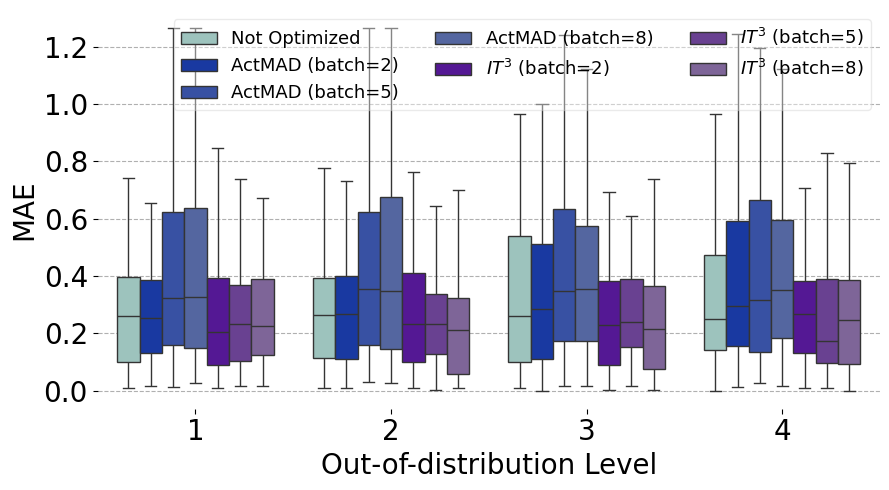

In [18]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
# Example extended data (more data points for each combination)

fontsize = 20

data = {
    'Method': ['Not Optimized'] * len(NOT_OPTIMIZED) + ["ActMAD (batch=2)"] * len(ACTMAD_2_batch) + ["ActMAD (batch=5)"] * len(ACTMAD_5_batch) + ["ActMAD (batch=8)"] * len(ACTMAD_8_batch) + ['$IT^3$ (batch=2)'] * len(ITTT_BATCH_2) + ['$IT^3$ (batch=5)'] * len(ITTT_BATCH_5) + ["$IT^3$ (batch=8)"] * len(ITTT_BATCH_8),
    'Out-of-distribution Level': ([1] * M + [2] * M + [3] * M + [4] * M) * 7,
    'Accuracy': NOT_OPTIMIZED + ACTMAD_2_batch + ACTMAD_5_batch + ACTMAD_8_batch + ITTT_BATCH_2 + ITTT_BATCH_5 + ITTT_BATCH_8
}
# Convert the dictionary to a Pandas DataFrame
df = pd.DataFrame(data)
# Define custom colors for each method
custom_palette = {
    'Not Optimized': '#96CAC1',      # Green
    "ActMAD (batch=2)": "#022db8e3",
    "ActMAD (batch=5)": "#2647b5e3",
    "ActMAD (batch=8)": "#475fade3",
#     'ITTT (batch=1)': '#FFDAB9', # Yellow
#     'ITTT (batch=4)': '#C1BED6',   # Violet
#     'ITTT (batch=8)': '#EA8E83'   # Red
    '$IT^3$ (batch=2)': '#5304a8e3', # Yellow
    '$IT^3$ (batch=5)': '#69349ee3', # Yellow
    '$IT^3$ (batch=8)': '#7e5ca1e3', # Yellow
}
# Create the seaborn boxplot with custom colors
plt.figure(figsize=(9, 5))
sns.boxplot(x='Out-of-distribution Level', y='Accuracy', hue='Method', data=df, palette=custom_palette, showfliers=False)
# Customize the plot
# plt.title('Accuracy by Method and Severity', fontsize=fontsize)
plt.xlabel('Out-of-distribution Level', fontsize=fontsize)
plt.ylabel('MAE', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(fontsize=fontsize-7, ncol=3, framealpha=0.4)

plt.grid(True, axis='y', linestyle='--') 
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

plt.tight_layout()